Chapter 16. Automated Trading

In [1]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import cufflinks as cf
from pylab import mpl, plt

In [2]:
np.random.seed(1000)
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'

In [3]:
p = 0.55  

In [4]:
f = p-(1-p)

In [5]:
f

0.10000000000000009

In [6]:
I =50


In [7]:
n = 100

In [10]:
def run_simulation(f):
    c = np.zeros((n, I))  
    c[0] = 100  
    for i in range(I):  
        for t in range(1, n):  
            o = np.random.binomial(1, p)  
            if o > 0:  
                c[t, i] = (1 + f) * c[t - 1, i]  
            else:  
                c[t, i] = (1 - f) * c[t - 1, i]  
    return c

In [11]:
c_1 = run_simulation(f)  

In [12]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]],
      shape=(100, 50))

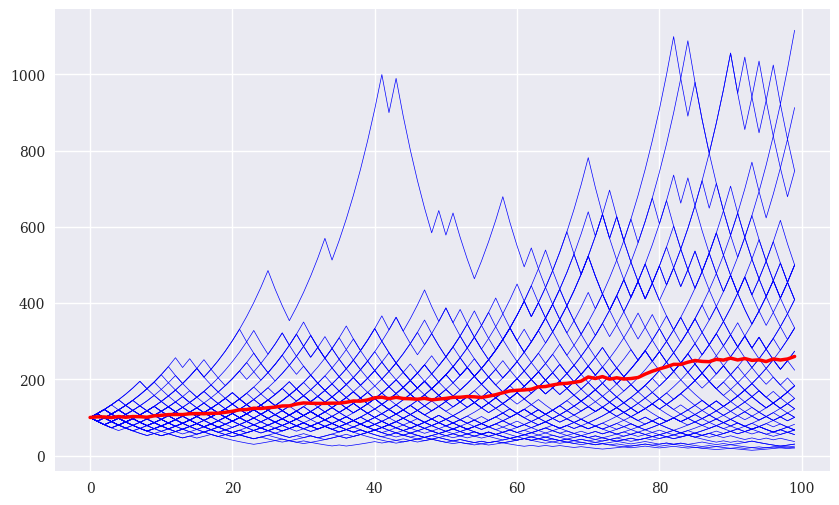

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)  
plt.plot(c_1.mean(axis=1), 'r', lw=2.5);  
# plt.savefig('../../images/ch16/auto_plot_01.png');

Figure 16-1. 50 simulated series with 100 trials each (red line = average)


In [14]:
c_2 = run_simulation(0.05)  
c_3 = run_simulation(0.25)  
c_4 = run_simulation(0.5)  

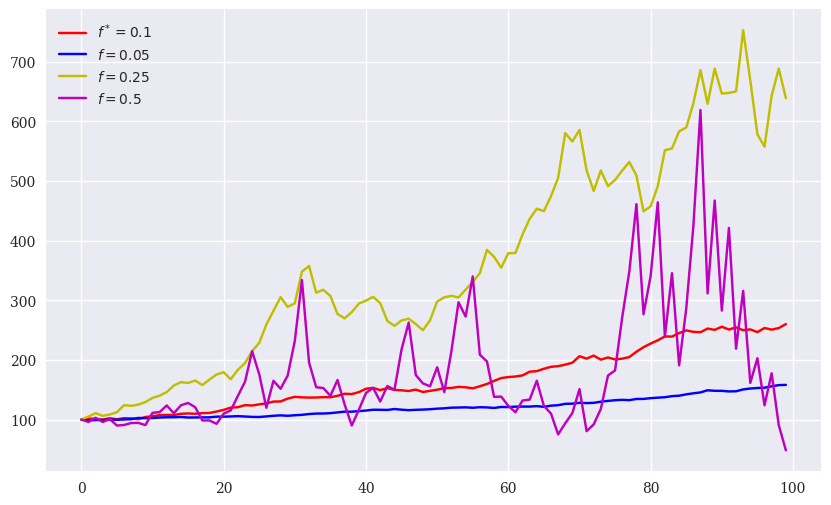

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0);

Figure 16-2. Average capital over time for different fractions


In [17]:
raw = pd.read_csv('tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [18]:
symbol = '.SPX'

In [19]:
data= pd.DataFrame(raw[symbol])

In [20]:
data['returns']= np.log(data/data.shift(1))

In [21]:
data.dropna(inplace=True)

In [22]:
data.tail()

,.SPX,returns
Date,,
2018-06-25,2717.07,-0.013820
2018-06-26,2723.06,0.002202
2018-06-27,2699.63,-0.008642
2018-06-28,2716.31,0.006160
2018-06-29,2718.37,0.000758


In [23]:
mu = data.returns.mean() * 252  

In [24]:
mu

np.float64(0.09898579893004976)

In [25]:
sigma = data.returns.std() * 252 ** 0.5  

In [26]:
sigma

np.float64(0.1488567510081967)

In [27]:
r= 0.0

In [ ]:
f= (mu-r)/sigma**2 #Calculates the optimal Kelly fraction to be invested in the strategy

In [29]:
f

np.float64(4.4672043679706865)

In [30]:
equs=[]

In [31]:
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1.  
    data[cap] = data[equ] * f  
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]  
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['returns'].loc[t])  
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
                            data[equ].loc[t_1]  
        data.loc[t, cap] = data[equ].loc[t] * f  

In [32]:
kelly_strategy(f * 0.5)  
kelly_strategy(f * 0.66)  
kelly_strategy(f)  

print(data[equs].tail())

            equity_2.23  equity_2.95  equity_4.47
Date                                             
2018-06-25     4.707070     6.367340     8.794342
2018-06-26     4.730248     6.408727     8.880952
2018-06-27     4.639340     6.246147     8.539593
2018-06-28     4.703365     6.359932     8.775296
2018-06-29     4.711332     6.374152     8.805026


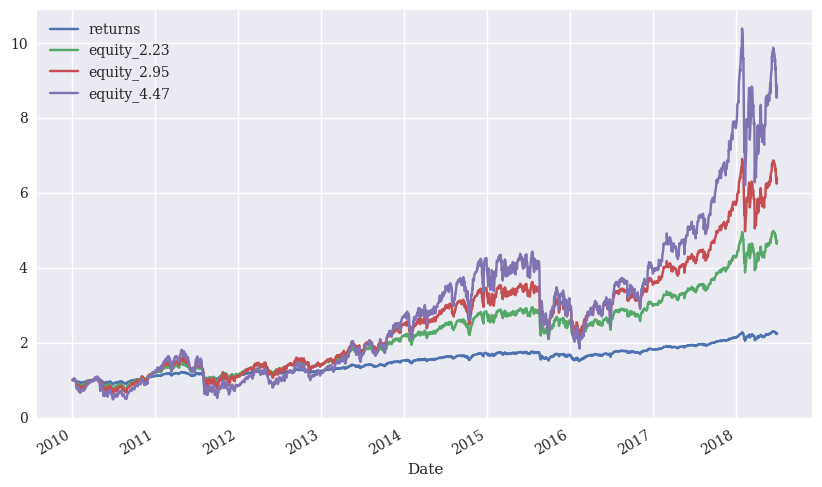

In [33]:
ax = data['returns'].cumsum().apply(np.exp).plot(legend=True, figsize=(10, 6))
data[equs].plot(ax=ax, legend=True);


Figure 16-3. Cumulative performance of S&P 500 compared to equity position given
different values of f